## En este codigo entreno los modelos de red Densa y de red Convolucional.

Importacion de librerias:

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2024-06-24 18:50:56.854718: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 18:50:57.030791: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 18:50:57.701146: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 18:50:59.163505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
columns = ["tension"]

Visualizacion de medicion.

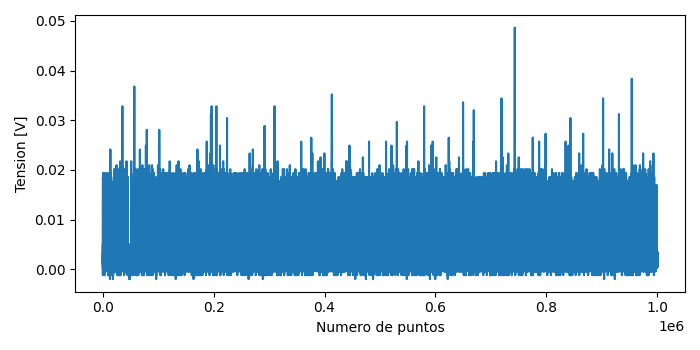

In [3]:
%matplotlib widget
dat = pd.read_csv("5.Wfm.csv", sep = ';')
dat.columns = columns
dat = -dat
plt.figure()
plt.plot(dat.tension)
plt.xlabel("Numero de puntos")
plt.ylabel("Tension [V]")
plt.show()  

Aca separo los pulsos y los guardo en el array VecPulses[], esto es simplemente poner un threshold que indica que hay un foton. Si no supero el threshold, avanzo un punto, si lo encuentro, avanzo 50 ns (50 puntos) que corresponde al tiempo de respuesta del MPPC y donde se supone que no deberia haber otro foton, salvo en el caso de AfterPulse.

1 Gsample/s -> 1 ns = 1 sample

In [4]:
num_puntos = 60
punto_final = 50 
threshold_1foton = 0.013

VecPulses = np.zeros((0,num_puntos))
Pulse = np.zeros(num_puntos)
k = 0
i = 100
while i< dat.size-500:
    if dat.tension[i] > threshold_1foton:
        k=k+1
        for j in range(num_puntos):
            Pulse[j] = dat.tension[i+j-(num_puntos-punto_final)]
        VecPulses = np.append(VecPulses, Pulse)
        VecPulses = VecPulses.reshape((k,num_puntos))
        i = i+punto_final
        
        continue
    else:
        i += 1
        continue

Codigo para visualizar los pulsos uno por uno.

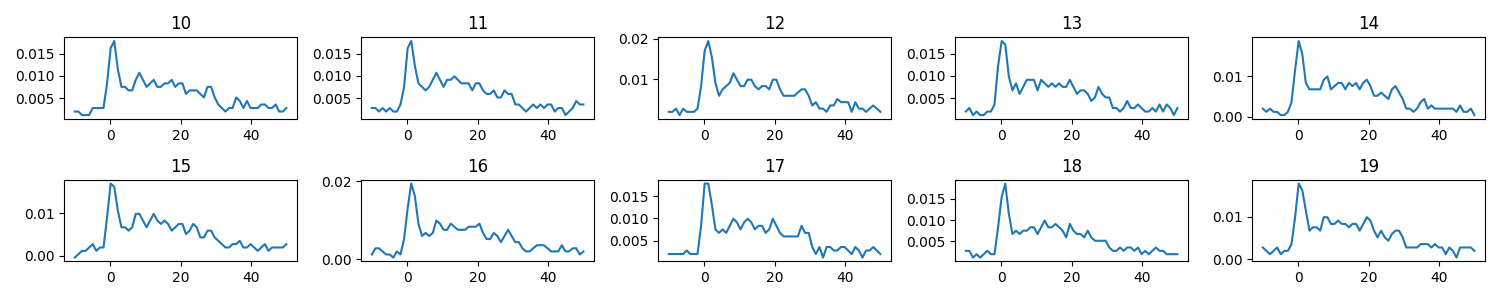

In [5]:
t = np.linspace(punto_final-num_puntos, punto_final, num_puntos)
m = 1
m = m-1
plt.close()
plt.figure(figsize=(15,3))
for l in range(10+m*10,20+m*10):
    plt.subplot(2,5, l+1-(10+m*10))
    plt.plot(t, VecPulses[l])
    plt.title(l)

Esto es solo para ver los datos de entrenamiento

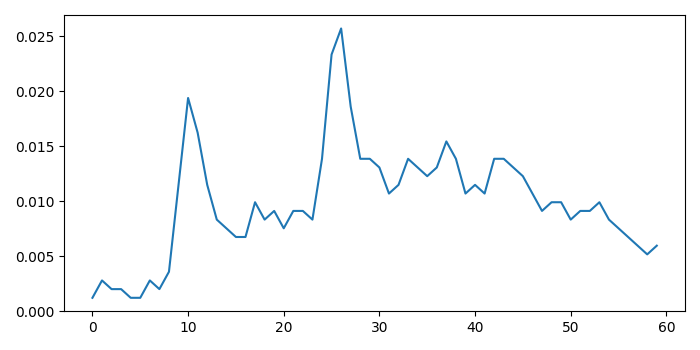

In [7]:
buffer = pd.read_csv("1_a.csv")
columns = ["time", "tension"]
buffer.columns = columns
plt.close()
plt.figure()
plt.plot(buffer.time, buffer.tension)
plt.show()

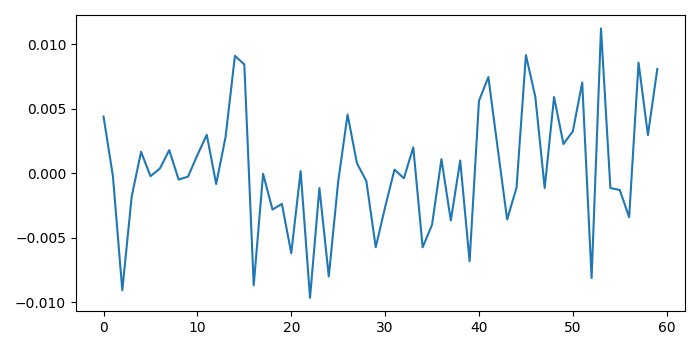

In [8]:
white_noise = np.random.normal(0, 0.005, num_puntos)
plt.close()
plt.figure()
plt.plot(white_noise)

Esta parte es de data augmentation. Debido a que es dificil encontrar datos a mano para entrenar la red, ya que son mas bien raros, me canse a los 35 de cada uno y decidi sumarles ruido para obtener un total de 350 pulsos de cada tipo para entrenar las redes.

In [9]:
datos_pulso = np.zeros((350, num_puntos))
datos_afterpulse = np.zeros((350, num_puntos))
datos_doble_pulso = np.zeros((350, num_puntos))
columns = ["time", "tension"]

for i in range(35):
    dat_p = pd.read_csv(str(i+1)+"_f.csv")
    dat_p.columns = columns
    datos_pulso[i] = dat_p.tension
    dat_a = pd.read_csv(str(i+1)+"_a.csv")
    dat_a.columns = columns
    datos_afterpulse[i] = dat_a.tension
    dat_d = pd.read_csv(str(i+1)+"_d.csv")
    dat_d.columns = columns
    datos_doble_pulso[i] = dat_d.tension

for i in range(35,350,1):
    white_noise = np.random.normal(0, 0.001, num_puntos)
    dat_p = pd.read_csv(str(i%35+1)+"_f.csv")
    dat_p.columns = columns
    datos_pulso[i] = dat_p.tension + white_noise
    dat_a = pd.read_csv(str(i%35+1)+"_a.csv")
    dat_a.columns = columns
    datos_afterpulse[i] = dat_a.tension+white_noise
    dat_d = pd.read_csv(str(i%35+1)+"_d.csv")
    dat_d.columns = columns
    datos_doble_pulso[i] = dat_d.tension+white_noise


Solo para visualizar los datos de entrenamiento

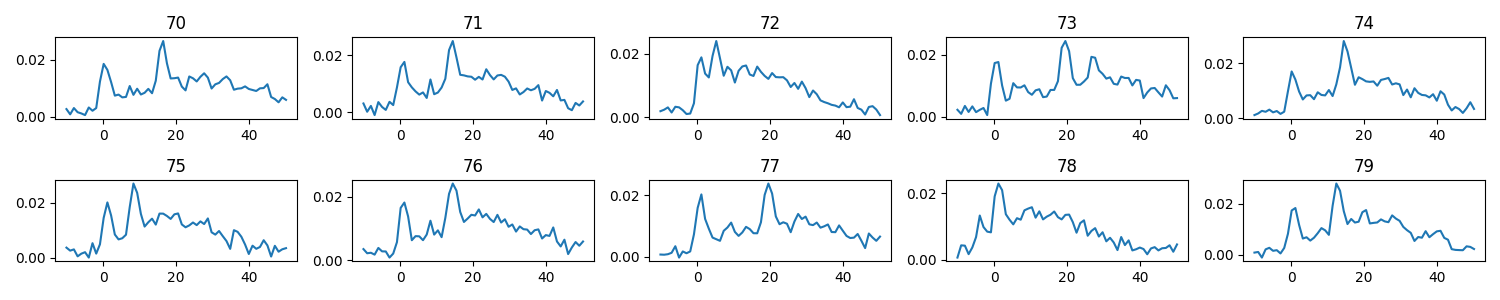

In [23]:
t = np.linspace(punto_final-num_puntos, punto_final, num_puntos)
m = 7
m = m-1
plt.close()
plt.figure(figsize=(15,3))
for l in range(10+m*10,20+m*10):
    plt.subplot(2,5, l+1-(10+m*10))
    plt.plot(t, datos_afterpulse[l])
    plt.title(l)

Le pongo las labels a cada tipo

In [24]:
pulso_label = np.zeros((350,1))
afterpulse_label = np.zeros((350,1))
doble_pulso_label = np.zeros((350,1))
for i in range(350):
    pulso_label[i] = 0
for i in range(350):
    afterpulse_label[i] = 1
for i in range(350):
    doble_pulso_label[i] = 2

data = np.vstack((datos_pulso, datos_afterpulse, datos_doble_pulso))
labels = np.vstack((pulso_label, afterpulse_label,doble_pulso_label))

Shuffle y split

In [25]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
split_ratio = 0.8
split_index = int(data.shape[0] * split_ratio)

x_train, x_test = data[:split_index], data[split_index:]
y_train, y_test = labels[:split_index], labels[split_index:] 

Definicion de la red Densa y entrenamiento

In [34]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(num_puntos,)),  ## La entrada son la cantidad de puntos que tiene un pulso
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'), 
    keras.layers.Dense(3, activation='softmax') ## La salida son los tres casos posibles
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])  

history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4063 - loss: 1.0975 - val_accuracy: 0.9167 - val_loss: 1.0906
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8666 - loss: 1.0888 - val_accuracy: 0.8988 - val_loss: 1.0794
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9403 - loss: 1.0761 - val_accuracy: 0.9702 - val_loss: 1.0592
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9293 - loss: 1.0539 - val_accuracy: 0.9286 - val_loss: 1.0272
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9100 - loss: 1.0177 - val_accuracy: 0.9524 - val_loss: 0.9724
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9593 - loss: 0.9599 - val_accuracy: 0.9464 - val_loss: 0.8951
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9284 - loss: 0.8830 - val_accuracy: 0.9583 - val_loss: 0.7985
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9710 - loss: 0.7860 - val_accuracy: 0.9345 - 

La guardo

In [35]:
model.save('model_dense.h5')

Evaluacion del modelo

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.0281 
Precisión en el conjunto de prueba: 0.9857142567634583


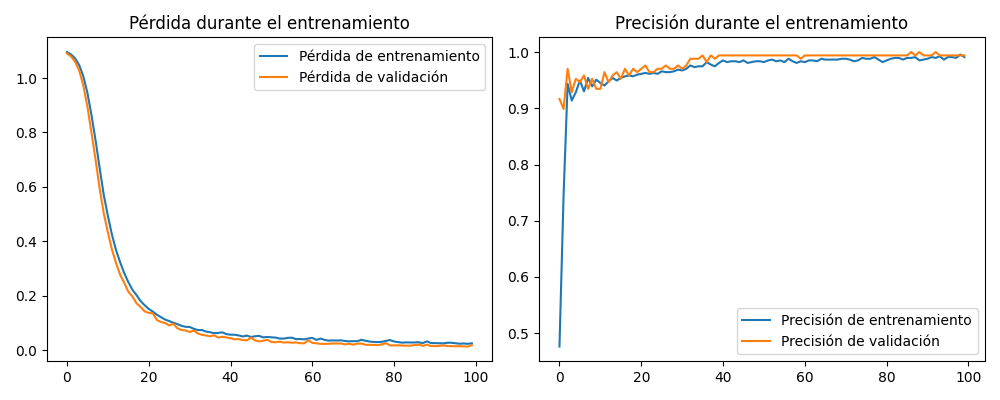

In [36]:

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Precisión en el conjunto de prueba:", test_accuracy)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.legend()
plt.title('Pérdida durante el entrenamiento')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.legend()
plt.title('Precisión durante el entrenamiento')

plt.show()

Ahora lo mismo pero la convolucional

In [43]:
model = models.Sequential()

model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(60, 1)))
model.add(layers.MaxPooling1D(2))


model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
labels_type1 = np.zeros((350, 1))
labels_type2 = np.ones((350, 1))
labels_type3 = np.full((350, 1), 2)

data = np.vstack((datos_pulso, datos_afterpulse, datos_doble_pulso))
labels = np.vstack((labels_type1, labels_type2, labels_type3))

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

One hot encoding y reshape.

In [45]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=31)

y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

Entreno

In [46]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3655 - loss: 1.0985 - val_accuracy: 0.3690 - val_loss: 1.0936
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3683 - loss: 1.0953 - val_accuracy: 0.3690 - val_loss: 1.0804
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4369 - loss: 1.0755 - val_accuracy: 0.6607 - val_loss: 1.0224
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8313 - loss: 0.9460 - val_accuracy: 0.8333 - val_loss: 0.7138
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8718 - loss: 0.6000 - val_accuracy: 0.9107 - val_loss: 0.3435
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9324 - loss: 0.2646 - val_accuracy: 0.9405 - val_loss: 0.1903
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9509 - loss: 0.1763 - val_accuracy: 0.9643 - val_loss: 0.1760
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9576 - loss: 0.1326 - val_accuracy: 0.928

Evaluacion

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9856 - loss: 0.0198 
Test accuracy: 0.9904761910438538


Text(0.5, 1.0, 'Precisión durante el entrenamiento')

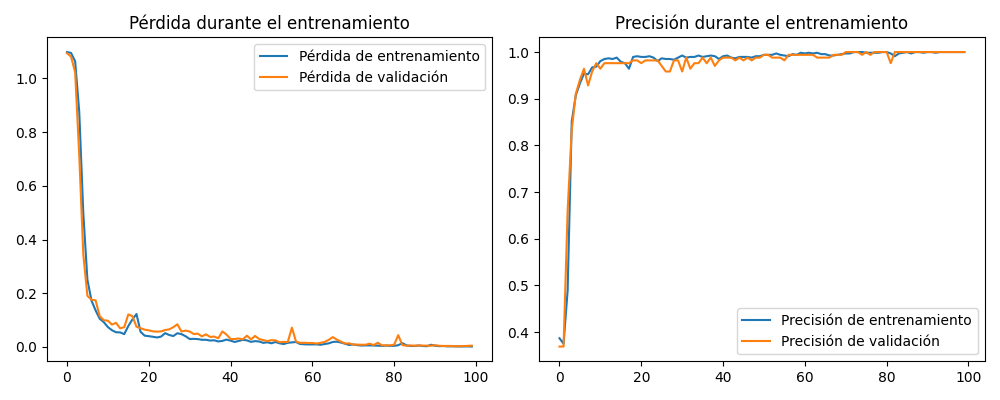

In [47]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.legend()
plt.title('Pérdida durante el entrenamiento')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.legend()
plt.title('Precisión durante el entrenamiento')


In [48]:
model.save("model_cnn.h5")